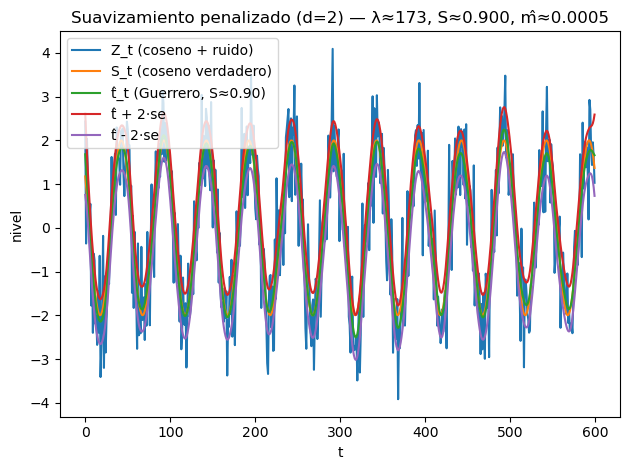

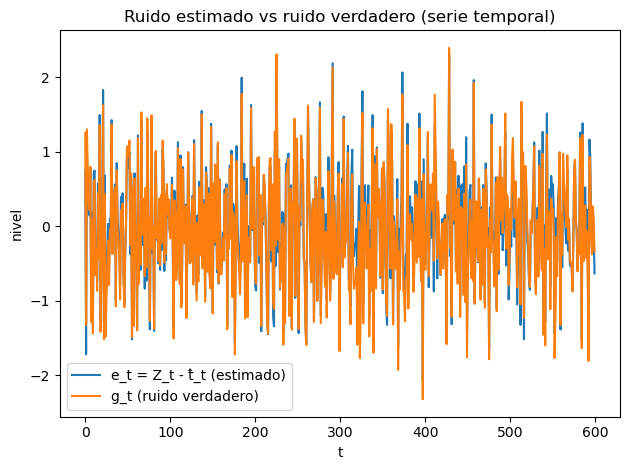

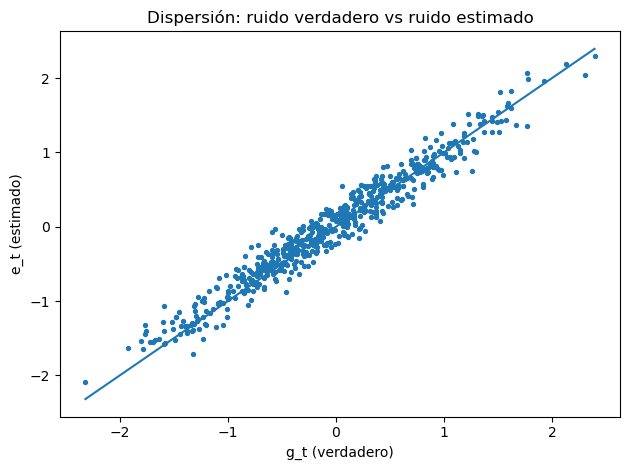

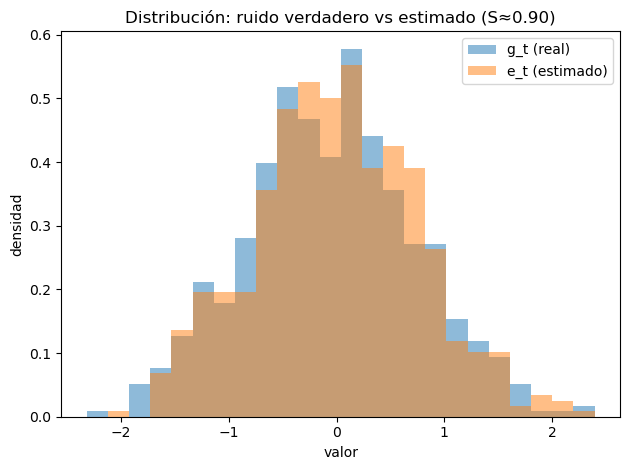

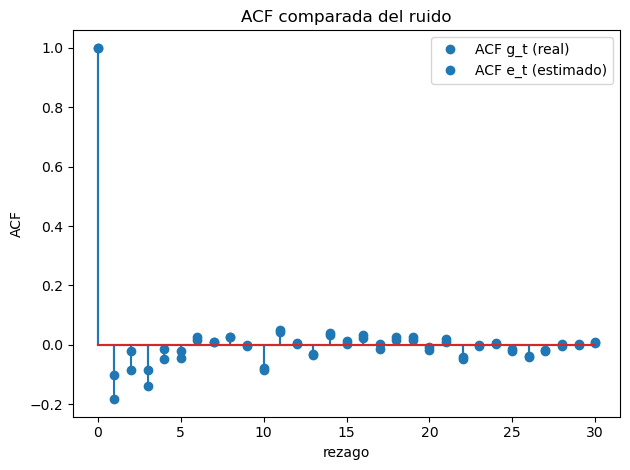

=== Métricas rápidas ===
RMSE(t̂, S) = 0.1758
Var(e)/Var(g) = 0.9257
KS: D=0.0500, p≈0.4274


In [2]:
# Patch: remove the unsupported keyword 'use_line_collection' from plt.stem
# and set labels via the returned artists to keep legends working across
# Matplotlib versions. Also bundle the whole demo into a fixed script.

import numpy as np
import matplotlib.pyplot as plt

def comb(n, k):
    from math import comb as c
    return c(n, k)

def difference_matrix(N: int, d: int):
    if d == 0:
        return np.eye(N)
    K = np.zeros((N - d, N))
    coeffs = np.array([(-1)**(d-k) * comb(d, k) for k in range(d+1)], dtype=float)
    for row in range(N - d):
        K[row, row:row + d + 1] = coeffs
    return K

def fit_penalized_trend(Z, d=2, lam=None, S_target=None, max_iter=200, tol=1e-11):
    Z = np.asarray(Z, dtype=float).ravel()
    N = Z.size
    I = np.eye(N)
    K = difference_matrix(N, d)
    KT_K = K.T @ K
    K1 = K.T @ np.ones(K.shape[0])

    def Ainv(lmb):
        from numpy.linalg import inv
        return inv(I + lmb * KT_K)

    def S_index(lmb):
        if d == 0:
            return lmb/(1.0+lmb)
        Ainv_ = Ainv(lmb)
        return 1.0 - (np.trace(Ainv_) / N)

    if lam is None:
        if S_target is None:
            S_target = 0.90
        lo, hi = 1e-9, 1e9
        for _ in range(50):
            mid = np.sqrt(lo*hi)
            Smid = S_index(mid)
            if Smid < S_target:
                lo = mid
            else:
                hi = mid
        lam = mid

    Ainv_ = Ainv(lam)
    m = float(np.mean(K @ Z))
    for _ in range(max_iter):
        t_hat = Ainv_ @ (Z + lam * m * K1)
        m_new = float(np.mean(K @ t_hat))
        if abs(m_new - m) < tol:
            m = m_new
            break
        m = m_new

    resid = Z - t_hat
    pen = K @ t_hat - m
    dof = max(1, N - d - 1)
    sigma2_hat = (resid @ resid + lam * (pen @ pen)) / dof
    S_val = S_index(lam)
    return {"t_hat": t_hat, "m_hat": m, "lam": lam, "S": S_val, "sigma2_hat": sigma2_hat, "Ainv": Ainv_, "K": K, "Z": Z, "d": d}

def acf(x, max_lag=20):
    x = np.asarray(x) - np.mean(x)
    n = len(x)
    out = np.empty(max_lag+1)
    var = np.dot(x,x)/n
    for k in range(max_lag+1):
        out[k] = np.dot(x[:n-k], x[k:]) / n / var
    return out

# --- Demo minimal reproducible (uses synthetic cosine) ---
def run_demo_and_plot():
    N = 600; A = 2.0; period = 50; phi = 0.3*np.pi; sigma = 0.8
    t = np.arange(N, dtype=float)
    S = A*np.cos(2*np.pi*t/period + phi)
    rng = np.random.default_rng(20250812)
    g = rng.normal(0.0, sigma, size=N)
    Z = S + g

    res_S90 = fit_penalized_trend(Z, d=2, S_target=0.90)
    t_hat = res_S90["t_hat"]; m_hat = res_S90["m_hat"]
    lam = res_S90["lam"]; Sval = res_S90["S"]
    Ainv = res_S90["Ainv"]; sigma2_hat = res_S90["sigma2_hat"]
    se = np.sqrt(np.maximum(0.0, sigma2_hat) * np.diag(Ainv))

    # 1) Main plot
    plt.figure()
    plt.plot(Z, label="Z_t (coseno + ruido)")
    plt.plot(S, label="S_t (coseno verdadero)")
    plt.plot(t_hat, label=f"t̂_t (Guerrero, S≈{Sval:.2f})")
    plt.plot(t_hat + 2*se, label="t̂ + 2·se")
    plt.plot(t_hat - 2*se, label="t̂ - 2·se")
    plt.title(f"Suavizamiento penalizado (d=2) — λ≈{lam:.3g}, S≈{Sval:.3f}, m̂≈{m_hat:.4f}")
    plt.xlabel("t"); plt.ylabel("nivel"); plt.legend(); plt.tight_layout(); plt.show()

    # 2) Residual vs true noise
    e = Z - t_hat
    plt.figure()
    plt.plot(e, label="e_t = Z_t - t̂_t (estimado)")
    plt.plot(g, label="g_t (ruido verdadero)")
    plt.title("Ruido estimado vs ruido verdadero (serie temporal)")
    plt.xlabel("t"); plt.ylabel("nivel"); plt.legend(); plt.tight_layout(); plt.show()

    # 3) Scatter e vs g
    plt.figure()
    plt.scatter(g, e, s=8)
    lims = [min(g.min(), e.min()), max(g.max(), e.max())]
    plt.plot(lims, lims)
    plt.title("Dispersión: ruido verdadero vs ruido estimado")
    plt.xlabel("g_t (verdadero)"); plt.ylabel("e_t (estimado)"); plt.tight_layout(); plt.show()

    # 4) Histogram (side-by-side via overlapping bars)
    plt.figure()
    data_all = np.r_[g, e]
    bins = np.histogram_bin_edges(data_all, bins="fd")
    h_g, edges = np.histogram(g, bins=bins, density=True)
    h_e, _     = np.histogram(e, bins=bins, density=True)
    centers = 0.5*(edges[1:]+edges[:-1]); width = np.diff(edges)
    plt.bar(centers, h_g, align="center", width=width, alpha=0.5, label="g_t (real)")
    plt.bar(centers, h_e, align="center", width=width, alpha=0.5, label="e_t (estimado)")
    plt.title("Distribución: ruido verdadero vs estimado (S≈0.90)")
    plt.xlabel("valor"); plt.ylabel("densidad"); plt.legend(); plt.tight_layout(); plt.show()

    # 5) ACF with legacy-friendly stem (no 'use_line_collection'; set label via artist)
    lags = np.arange(31)
    v_g = acf(g, max_lag=30)
    v_e = acf(e, max_lag=30)
    plt.figure()
    m1, s1, b1 = plt.stem(lags, v_g)
    m1.set_label("ACF g_t (real)")
    m2, s2, b2 = plt.stem(lags, v_e)
    m2.set_label("ACF e_t (estimado)")
    plt.title("ACF comparada del ruido")
    plt.xlabel("rezago"); plt.ylabel("ACF"); plt.legend(); plt.tight_layout(); plt.show()

    # Metrics (print)
    rmse_S = float(np.sqrt(np.mean((t_hat - S)**2)))
    var_ratio = float(np.var(e, ddof=1)/np.var(g, ddof=1))
    try:
        from scipy.stats import ks_2samp
        ks_stat, ks_p = ks_2samp(g, e, alternative="two-sided", mode="asymp")
    except Exception:
        ks_stat, ks_p = np.nan, np.nan
    print("=== Métricas rápidas ===")
    print(f"RMSE(t̂, S) = {rmse_S:.4f}")
    print(f"Var(e)/Var(g) = {var_ratio:.4f}")
    print(f"KS: D={ks_stat:.4f}, p≈{ks_p:.4f}")

    return {"Z": Z, "S": S, "t_hat": t_hat, "e": e, "g": g}

# Run now to verify the fix in this environment
_ = run_demo_and_plot()

voy a hacer varias preguntas

1. como encontraste al lambda?
2. me puedes decir que significa cada grafica?
3. como estimaste el ruido?
4. por que sirve hacer una ACF para el ruido?

¡Vamos por partes, Heri!

## 1) ¿Cómo encontré $\lambda$?

* **Criterio operativo (realista, sin conocer la “verdad”):** fijé un **índice de suavidad objetivo** $S\in(0,1)$ y resolví $\lambda$ por bisección usando la identidad de Guerrero (para $d\ge1$):

$$
S(\lambda)=1-\frac{1}{N}\operatorname{tr}\!\Big[(I+\lambda K_d'K_d)^{-1}\Big],\qquad
S_0(\lambda)=\frac{\lambda}{1+\lambda}.
$$

Monótono en $\lambda$: $\lambda\downarrow\Rightarrow S\downarrow$ (más fidelidad, menos suavidad); $\lambda\uparrow\Rightarrow S\uparrow$ (más suavidad). Elegí $S\approx 0.90$ $\Rightarrow$ busqué $\lambda$ tal que $S(\lambda)\approx 0.90$.

* **Criterio “oráculo” (solo en la demo del coseno):** como conocíamos la señal verdadera $S_t$, barrí $\lambda$ en rejilla logarítmica y tomé

$$
\lambda_{\text{oracle}}=\arg\min_\lambda \mathrm{RMSE}\big(\hat{\mathbf t}(\lambda),\mathbf S\big).
$$

Esto NO se puede en datos reales, pero sirve para calibrar la intuición.

**Intuición:** resolvemos

$$
\min_{\mathbf t,m}\ \underbrace{\|\mathbf Z-\mathbf t\|_2^2}_{\text{fidelidad}}+\lambda\,\underbrace{\|K_d\mathbf t-\mathbf 1\,m\|_2^2}_{\text{suavidad en }\Delta^d t_t \text{ alrededor de } m},
$$

y $\lambda$ pondera el **compromiso sesgo–varianza**: $\lambda$ grande aplana (penaliza curvatura), $\lambda$ pequeño deja pasar estructura de alta frecuencia.

---

## 2) ¿Qué significa cada gráfica?

1. **Serie y tendencia con bandas**: $Z_t$ (observado), $S_t$ (coseno verdadero, solo en la demo), $\hat t_t$ (tendencia estimada) y bandas **puntuales** $\hat t_t\pm 2\,\mathrm{se}_t$, donde

$$
\operatorname{Var}(\hat{\mathbf t})=\hat\sigma^2\,(I+\lambda K_d'K_d)^{-1},\quad
\mathrm{se}_t=\sqrt{\hat\sigma^2\big[(I+\lambda K_d'K_d)^{-1}\big]_{tt}}.
$$

Lectura: cuán suave quedó la tendencia y qué tan grande es la incertidumbre local.
2\) **Ruido estimado vs ruido verdadero (en tiempo):** compara $e_t=Z_t-\hat t_t$ con $g_t$ (ruido simulado). Idealmente $e_t\approx g_t$: sincronía y amplitud similar indican buena extracción.
3\) **Dispersión $g_t$ vs $e_t$:** si los puntos se alinean en la diagonal $y=x$, entonces $e_t$ **recupera** el ruido (pendiente $\approx1$, $R^2$ alto). Sesgo vertical/horizontal = sobre/sub‐suavizado.
4\) **Histograma (densidad) de $g_t$ y $e_t$:** contrasta la **ley marginal** del ruido recuperado; diferencias en colas o curtosis señalan $\lambda$ subóptimo o no gaussianidad.
5\) **ACF de $g_t$ y $e_t$:** inspección de **blancura**. Una ACF plana de $e_t$ (como la de $g_t$) sugiere que en la tendencia ya se absorbió la estructura serial.

---

## 3) ¿Cómo estimé el ruido?

* Primero estimo $(\hat{\mathbf t},\hat m)$ resolviendo el sistema normal (forma cerrada con punto fijo en $\hat m$):

$$
\hat{\mathbf t}=(I+\lambda K_d'K_d)^{-1}\big(\mathbf Z+\lambda \hat m\,K_d'\mathbf 1\big),\qquad
\hat m=\frac{1}{N-d}\mathbf 1'(K_d\hat{\mathbf t}).
$$

* Luego defino el **ruido estimado** como el **residuo**:

$$
e_t \;=\; Z_t-\hat t_t.
$$

* La **varianza del ruido** la estimé (corrigiendo por penalización y por estimar $m$) como

$$
\hat\sigma^2=\frac{\sum_t(Z_t-\hat t_t)^2+\lambda\sum_t\big(\Delta^d\hat t_t-\hat m\big)^2}{N-d-1}.
$$

**Nota conceptual:** $e_t$ es el mejor estimador lineal del ruido **bajo el modelo** (innovaciones i.i.d. y el tipo de suavidad postulado). Si el señal “verdadera” no encaja bien con la penalización (p.ej. un coseno con $d=2$ implica $\Delta^2 S_t$ oscilante, no constante), parte de esa periodicidad puede “fugarse” a $e_t$, y la ACF lo delata.

---

## 4) ¿Por qué sirve hacer una ACF del ruido?

Porque el supuesto de trabajo es que el **ruido** $g_t$ es **blanco** (no autocorrelacionado). Por tanto, tras separar la tendencia,

$$
\mathrm{ACF}_{e}(k)\approx 0\quad (k\ge 1)
$$

debería sostenerse **si** la tendencia capturó toda la dependencia serial de baja frecuencia. Si ves:

* **picos significativos** (Box–Ljung rechaza blancura) $\Rightarrow$ quedó **estructura** en los residuos → $\lambda$ demasiado bajo (sub–suavizado) o la **clase del filtro** no es la correcta (p.ej., falta un componente periódico explícito).
* **oscilación a la frecuencia de la señal** $\Rightarrow$ la penalización de orden $d$ no acomodó esa dinámica (pistas para mover $d$ o introducir un término periódico).
* **ACF negativa pronunciada a lag 1** $\Rightarrow$ posible **sobre–suavizado** (el residuo compensa con alternancia).

En resumen, la ACF es un **diagnóstico de especificación**: valida la hipótesis de innovaciones blancas tras la extracción de tendencia; si falla, ajustas $\lambda$, cambias $d$ o enriqueces el modelo (por ejemplo, tendencia penalizada + senoides, o componente estacional en estado–espacio).

---

### Micro–regla práctica

1. fija $S$ (o usa CV/GCV/criterios de blancura) $\rightarrow$ resuelve $\lambda$;
2. mira ACF de $e_t$ y **prueba de Ljung–Box**;
3. si hay estructura, sube $d$ o modela el componente que falta (p.ej. armónico);
4. reevalúa con histogramas/KS para la forma marginal del ruido.
